In [1]:
import cv2
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from skimage import color
from google.colab.patches import cv2_imshow
import tensorflow as tf

Mounted at /content/drive


In [2]:
def Hough(image, blur, p1, p2, minR, maxR):
    gray = image.astype('uint8')
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, blur)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT,1,gray.shape[0]/8, param1=p1,param2=p2,minRadius=minR,maxRadius=maxR)
    if circles is None:
      return None
    else:
      circles = np.uint16(np.around(circles))[0,:]
    # for i in range(len(circles)):
    #   center = (int(circles[i,0]),int(circles[i,1]))
    #   radius = circles[i,2]
    #   # cv2.circle(gray, center, 1, (0, 0, 0), 3)
    #   # cv2.circle(gray, center, radius, (255, 255, 255), 3)
    #   # cv2_imshow(gray)
      return circles

In [3]:
faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/def_front/'
ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/ok_front/'

directories = (faulty_dir, ok_dir)

# check the total number of images we have
faulty = 0
ok = 0
j = -1
for direct in directories:
  j += 1
  print(direct)
  for file in os.listdir(direct):
    # count only number of faulty images
    if j == 0:
      faulty += 1
    if j == 1:
      ok += 1

print(faulty, ok)
# set the values of the X and y arrays
num_images = faulty+ok
input_shape = (80, 80, 1)
height = input_shape[0]
width = input_shape[1]
channels = input_shape[2]

X = np.zeros((num_images,height,width,channels))

# populate the arrays
i = 0
for direct in directories:
  for file in os.listdir(direct):
    path = (direct+file)
    im = plt.imread(path)
    scaled_im = cv2.resize(im[:,:,0],(height,width))
    scaled_im = scaled_im[:, :, np.newaxis]
    X[i,:,:,:] = scaled_im
    i+=1

/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/def_front/
/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/ok_front/
781 519


In [4]:
background = cv2.imread('/content/drive/Shareddrives/Senior Thesis/Background_Hough.png')
print(background.shape)

(480, 640, 3)


In [5]:
def create_detect_data(data_size, background, X, num_im):
  height_back, width_back, channels = background.shape[0], background.shape[1], background.shape[2]
  ImTrain = np.zeros((data_size,height_back,width_back,channels))
  labels = []

  for i in range(data_size):
    background_copy = np.array(list(background))
    num = int(np.round((num_im-1)*np.random.uniform(0,1,1)+1))
    idxs = np.zeros((num, 2))
    count = 0
    while count != num:
      condition_go = np.zeros(count)
      random_pic = int(np.random.uniform(0,len(X),1))
      idx1 = int(np.random.uniform(80,height_back-height,1))
      idx2 = int(np.random.uniform(1,width_back-width,1))
      if count == 0: #if the num array does not have a value, add first entry
        idxs[count, :] = (idx1, idx2)
        background_copy[idx1:idx1+height,idx2:idx2+width,:] = X[random_pic]
        count += 1
      else:
        for k in range(count):
          condition1 = idxs[k,0]-80<=idx1 and idx1<=idxs[k,0]+80 #bounding boxes for overlapping images
          condition2 = idxs[k,1]-80<=idx2 and idx2<=idxs[k,1]+80
          condition_go[k] = int(not (condition1 and condition2))   
        if np.all(condition_go==1): 
          idxs[count, :] = (idx1, idx2)
          background_copy[idx1:idx1+height,idx2:idx2+width,:] = X[random_pic]
          count += 1
    ImTrain[i,:,:,:] = background_copy
    labels.append(idxs)
  labels = np.array(labels, dtype='object')
  return ImTrain, labels

In [6]:
X_train, y_train = create_detect_data(1000,background,X,5)

In [7]:
import time

blur = 3
p1 = 50
p2 = 30
minR = 20
maxR = 40
predict = []
time_predict = np.zeros(len(X_train))
for i in range(len(X_train)):
  start = time.time()
  circles = Hough(X_train[i], blur, p1, p2, minR, maxR)
  predict.append(circles)
  time_predict[i] = time.time()-start

predict = np.array(predict, dtype = 'object')

In [8]:
print(np.average(time_predict))
print(np.std(time_predict))
print(np.min(time_predict))
print(np.max(time_predict))

0.006786115884780884
0.0017472666045540547
0.00510096549987793
0.05674600601196289


In [9]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union

def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h

def iou(a, b):
	# a and b should be (x1,y1,x2,y2)
	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0
	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [19]:
# standard for circle image shape
height = 80
width = 80

def detection_loss(prediction, labels):
  av_IOU = np.zeros(len(prediction))
  total_IOU = []
  num_hit = np.zeros(len(prediction))
  for im in range(len(prediction)):
    guess = prediction[im]
    truth = labels[im]
    if guess is not None:
      guess = np.sort(guess, axis = 0)
      truth = np.sort(truth, axis = 0)
      num_hit[im] = (truth.shape[0]-guess.shape[0])
      area = 0
      # fewer guesses than truth
      if guess.shape[0] < truth.shape[0]:
        for obj in range(guess.shape[0]):
          x1, y1, x2, y2 = truth[obj,0], truth[obj,1], truth[obj,0]+height, truth[obj,1]+width
          px1, py1, px2, py2 = guess[obj,1]-guess[obj,2], guess[obj,0]-guess[obj,2], guess[obj,1]+guess[obj,2], guess[obj,0]+guess[obj,2]
          a = (x1,y1,x2,y2)
          b = (px1,py1,px2,py2)
          total_IOU.append(iou(a,b)+0.3)
          area = area + (iou(a,b)+0.3)/guess.shape[0]
      # more guesses than truth
      elif guess.shape[0] > truth.shape[0]:
        for obj in range(truth.shape[0]):
          x1, y1, x2, y2 = truth[obj,0], truth[obj,1], truth[obj,0]+height, truth[obj,1]+width
          px1, py1, px2, py2 = guess[obj,1]-guess[obj,2], guess[obj,0]-guess[obj,2], guess[obj,1]+guess[obj,2], guess[obj,0]+guess[obj,2]
          a = (x1,y1,x2,y2)
          b = (px1,py1,px2,py2)
          total_IOU.append(iou(a,b)+0.3)
          area = area + (iou(a,b)+0.3)/truth.shape[0]
      # equal guesses to truth
      else:
        for obj in range(truth.shape[0]):
          x1, y1, x2, y2 = truth[obj,0], truth[obj,1], truth[obj,0]+height, truth[obj,1]+width
          px1, py1, px2, py2 = guess[obj,1]-guess[obj,2], guess[obj,0]-guess[obj,2], guess[obj,1]+guess[obj,2], guess[obj,0]+guess[obj,2]
          a = (x1,y1,x2,y2)
          b = (px1,py1,px2,py2)
          total_IOU.append(iou(a,b)+0.3)
          area = area + (iou(a,b)+0.3)/truth.shape[0]
    av_IOU[im] = area
  total_IOU = np.array(total_IOU)
  return num_hit, av_IOU, total_IOU

In [24]:
num_hit, av_IOU, total_IOU = detection_loss(predict,y_train)
av_IOU_scaled = av_IOU/np.max(av_IOU)
total_IOU_scaled = total_IOU/np.max(total_IOU)

In [25]:
import matplotlib
print(np.average(av_IOU))
print(np.std(av_IOU))
print(np.min(av_IOU))
print(np.max(av_IOU))
print(np.array(np.where(num_hit!=0)).flatten().shape[0])
print(np.min(num_hit),np.max(num_hit))

0.9668168368991167
0.08357975924621502
0.5499999999609375
1.2024999998589843
0
0.0 0.0


In [46]:
thresh = np.arange(0.1,1,0.1)
TP = np.zeros(len(thresh))
FP = np.zeros(len(thresh)) #precision 
FN = np.zeros(len(thresh)) #recall
for j in range(len(thresh)):
  for i in total_IOU_scaled:
      if thresh[j]<i:
        TP[j] += 1
      else:
        FP[j] += 1

Text(0, 0.5, 'Count')

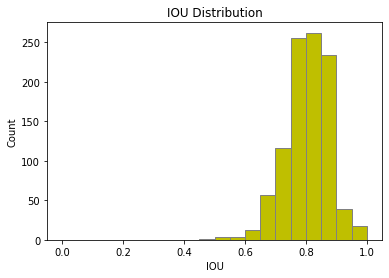

In [18]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as pyplot
...
fig = pyplot.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(av_IOU_scaled, bins=20, range=(0, 1), histtype='bar',facecolor='yellow', edgecolor='gray')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('y')

pyplot.title('IOU Distribution', )
pyplot.xlabel('IOU')
pyplot.ylabel('Count')

In [ ]:
print(np.argmin(av_IOU))
print(np.argmax(num_hit))
print(np.array(np.where(num_hit!=0)))

82
0
[]


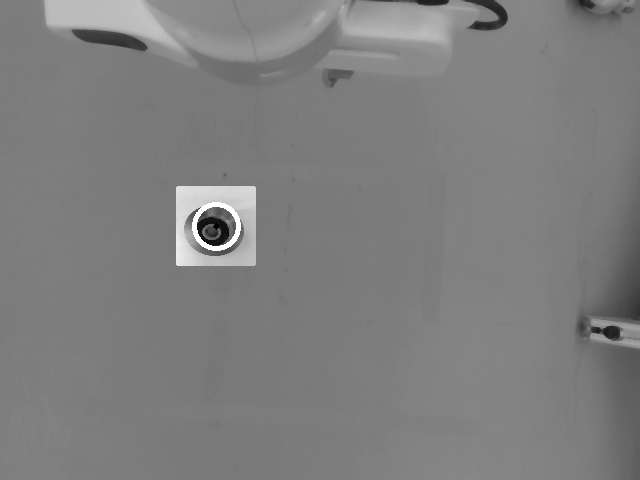

In [ ]:
i = 82
circles = predict[i]
gray = X_train[i]
gray = gray.astype('uint8')
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, blur)
for i in range(circles.shape[0]):
  center = (int(circles[i,0]),int(circles[i,1]))
  radius = circles[i,2]
  cv2.circle(gray, center, 1, (0, 0, 0), 3)
  cv2.circle(gray, center, radius, (255, 255, 255), 3)
cv2_imshow(gray)